## Estimate Quantities

In [1]:
# start by importing a few essentials
import numpy as np
import matplotlib.pyplot as plt
import astropy

from astropy.io import fits
from astropy.table import Table
import astropy.constants as const
import astropy.units as u

In [2]:
# MS Data

ms_file = '/Users/wanyan/Desktop/Astro/229/229_data/ms_updated.dat'
ms_dat = Table.read(ms_file, format='ascii.csv', delimiter=';')

print('MS Table \n')
ms_dat.pprint_all()

MS Table 

Spectral Type Temperature (K) Absolute Magnitude Luminosity (in solar luminosities) Mass (in solar masses)
------------- --------------- ------------------ ---------------------------------- ----------------------
            #              --                 --                                 --                     --
           O5          54,000              -10.0                            846,000                   30.3
           O6          45,000               -8.8                            275,000                   22.9
           O7          43,300               -8.6                            220,000                   21.7
           O8          40,600               -8.2                            150,000                   19.7
           O9          37,800               -7.7                             95,000                   17.6
           B0          29,200               -6.0                             20,000                   12.0
           B1          23,

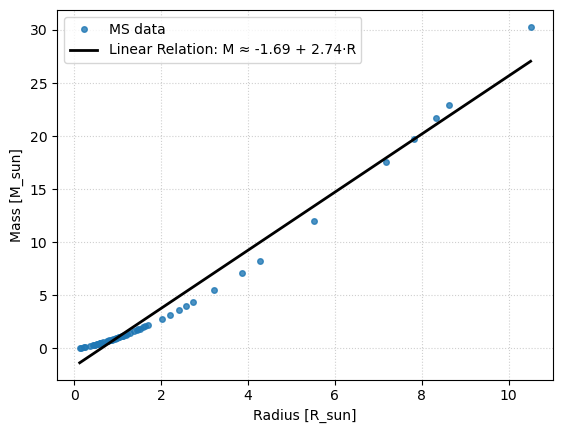

In [3]:
# Use Stefan–Boltzmann in solar ratios:
# L/Lsun = (R/Rsun)^2 (T/Tsun)^4  =>  R/Rsun = sqrt( (L/Lsun) / (T/Tsun)^4 )
T_sun = 5772.0  # K

def parse_numeric(col):
    out = []
    for v in col:
        s = str(v).replace(',', '').replace('*', '').strip()
        try:
            out.append(float(s))
        except Exception:
            out.append(np.nan)
    return np.array(out, dtype=float)

# Compute radius from Stefan–Boltzmann (solar units)
T = parse_numeric(ms_dat['Temperature (K)'])
L = parse_numeric(ms_dat['Luminosity (in solar luminosities)'])
M = parse_numeric(ms_dat['Mass (in solar masses)'])
R = np.sqrt(L / (T / T_sun)**4)

mask = np.isfinite(M) & np.isfinite(R) & (M > 0) & (R > 0)
R_plot = R[mask]
M_plot = M[mask]

# Linear Fit
b, a = np.polyfit(R_plot, M_plot, 1) 
M_hat = a + b * R_plot
r2 = 1.0 - np.sum((M_plot - M_hat)**2) / np.sum((M_plot - M_plot.mean())**2)

# Plot
fig, ax = plt.subplots()
ax.plot(R_plot, M_plot, 'o', ms=4, alpha=0.8, label='MS data')

rgrid = np.linspace(R_plot.min(), R_plot.max(), 200)
ax.plot(rgrid, a + b * rgrid, 'k-', lw=2, label=f'Linear Relation: M ≈ {a:.2f} + {b:.2f}·R')

ax.set_xlabel('Radius [R_sun]')
ax.set_ylabel('Mass [M_sun]')
ax.legend()
ax.grid(True, ls=':', alpha=0.6)
plt.show()

## Simple Model Fitting

In [4]:
# import the modeling tools
from astropy.modeling import models, fitting

In [5]:
# some numbers for the next cell
# be sure to use your data!
radii = R_plot
masses = M_plot

# define the model to fit - in this case, a linear function
# input a starting guess for the slope and intercept
t_init = models.Linear1D(slope=1, intercept=0)
# select the fitter to use
fit_t = fitting.TRFLSQFitter()
# fit the model to the data
t = fit_t(t_init, radii, masses, maxiter=200)

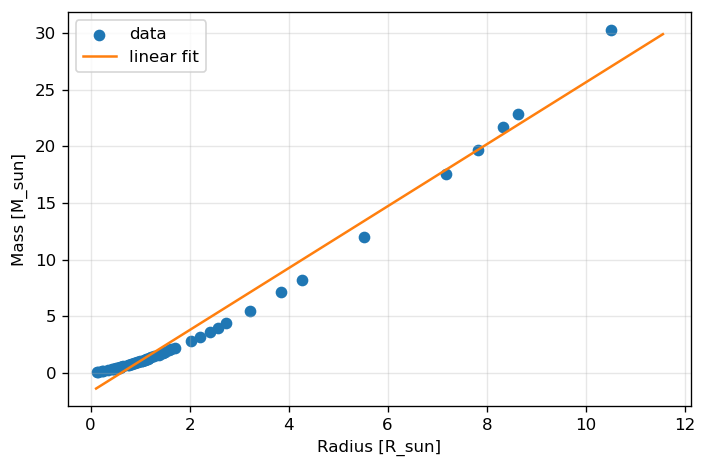

In [6]:
y_pred = t(radii)
ss_res = np.sum((masses - y_pred) ** 2)
ss_tot = np.sum((masses - np.mean(masses)) ** 2)
r2 = 1.0 - ss_res / ss_tot
rmse = np.sqrt(ss_res / radii.size)

# plot data and fit
x_plot = np.linspace(radii.min() * 0.9, radii.max() * 1.1, 200)
plt.figure(figsize=(6, 4), dpi=120)
plt.scatter(radii, masses, color="tab:blue", label="data")
plt.plot(x_plot, t(x_plot), color="tab:orange", label="linear fit")
plt.xlabel("Radius [R_sun]")
plt.ylabel("Mass [M_sun]")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# RMS error
y_pred = t(radii)
rmse = np.sqrt(np.mean((masses - y_pred) ** 2))  # RMS error
ss_res = np.sum((masses - y_pred) ** 2)
ss_tot = np.sum((masses - np.mean(masses)) ** 2)
r2 = 1.0 - ss_res / ss_tot

print(f"RMS = {rmse:.6f}")

RMS = 0.914628


Best RMS = 0.025892


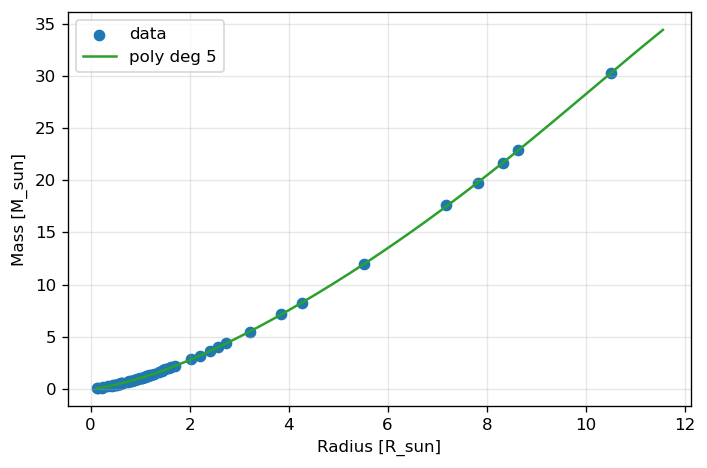

In [8]:
# helper function
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat) ** 2))

# possible choices
degrees = [2, 3, 4, 5]
lsq = fitting.LinearLSQFitter()
results = []

for d in degrees:
    model = models.Polynomial1D(degree=d)
    fit_model = lsq(model, radii, masses)
    yhat = fit_model(radii)
    rmse = np.sqrt(np.mean((masses - yhat) ** 2))
    results.append((d, fit_model, rmse))

# Choose the best polynomial
best_deg, best_model, best_rmse = min(results, key=lambda t: (t[2], t[0]))
print(f"Best RMS = {best_rmse:.6f}")

x_plot = np.linspace(radii.min() * 0.9, radii.max() * 1.1, 400)
plt.figure(figsize=(6, 4), dpi=120)
plt.scatter(radii, masses, color="tab:blue", label="data")
plt.plot(x_plot, best_model(x_plot), color="tab:green", label=f"poly deg {best_deg}")
plt.xlabel("Radius [R_sun]")
plt.ylabel("Mass [M_sun]")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Units and Numerical Precision

L ≈ 1 * M^3.998


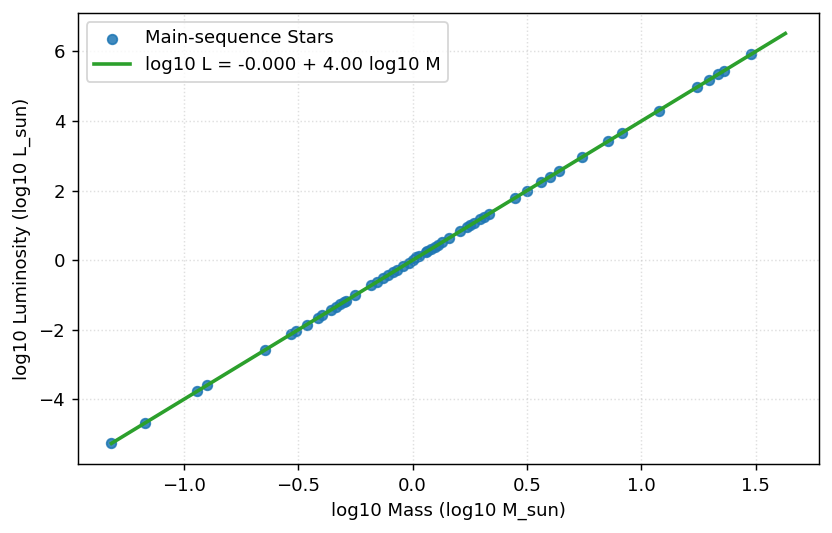

In [11]:
def parse_float(v):
    try:
        return float(str(v).replace(',', '').strip())
    except Exception:
        return np.nan

L = np.array([parse_float(v) for v in ms_dat['Luminosity (in solar luminosities)']], dtype=float)
M = np.array([parse_float(v) for v in ms_dat['Mass (in solar masses)']], dtype=float)

mask = np.isfinite(L) & np.isfinite(M) & (L > 0) & (M > 0)
L, M = L[mask], M[mask]

x = np.log10(M)        
y = np.log10(L)       
n = x.size
xbar, ybar = x.mean(), y.mean()
Sxx = np.sum((x - xbar) ** 2)
Syy = np.sum((y - ybar) ** 2)
Sxy = np.sum((x - xbar) * (y - ybar))

alpha = Sxy / Sxx                
beta  = ybar - alpha * xbar        
yhat  = alpha * x + beta
res   = y - yhat

sigma2    = np.sum(res**2) / (n - 2)
se_alpha  = np.sqrt(sigma2 / Sxx)
se_beta   = np.sqrt(sigma2 * (1.0/n + (xbar**2) / Sxx))

R2   = 1 - np.sum(res**2) / Syy
A    = 10**beta                

print(f"L ≈ {A:.3g} * M^{alpha:.3f}")

x_plot = np.linspace(x.min(), x.max()*1.1, 400)
y_fit  = alpha * x_plot + beta

plt.figure(figsize=(6.5, 4.2), dpi=130)
plt.scatter(x, y, s=28, alpha=0.85, label="Main-sequence Stars")
plt.plot(x_plot, y_fit, color="tab:green", lw=2.0,
         label=f"log10 L = {beta:.3f} + {alpha:.2f} log10 M")
plt.xlabel(r"log10 Mass (log10 M_sun)")
plt.ylabel(r"log10 Luminosity (log10 L_sun)")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.4)
plt.tight_layout()
plt.show()


## Fix Errors

### 1. Syntax Errors

In [14]:
# Q 1.1
def parsecs_to_light_years(parsecs):
    light_years = parsecs * 3.262
    return light_years

# Calculate light-years for a star 10 parsecs away
distance = 10
light_years = parsecs_to_light_years(distance)
print("Distance in light-years is: ", light_years) # added a comma here

Distance in light-years is:  32.62


In [15]:
# Q 1.2

def gravitational_force(mass1, mass2, distance):
    G = 6.674 * (10 ** -11)  # Gravitational constant
    force = (G * mass1 * mass2) / (distance ** 2) # cannot use ^ for power
    return force # miss this part, you need something to return to call this function for value

# Define masses in kilograms and distance in meters
mass_star1 = 1.989 * (10 ** 30)  # Mass of the sun
mass_star2 = 5.974 * (10 ** 24)   # Mass of the Earth
distance_apart = 1.496 * (10 ** 11)  # Distance in meters

# Calculate gravitational force
force = gravitational_force(mass_star1, mass_star2, distance_apart)
print("Gravitational force between the stars is: ", force)

Gravitational force between the stars is:  3.5434231374574625e+22


### 2. Runtime Errors

In [16]:
# Q 2.1

def average_distance(distances):
    total_distance = 0.0
    for element in distances:
        if element != None: # take care of None in the list
            total_distance += element
        else:
            continue
    return total_distance / len(distances)

# List of distances
planet_distances = [0.39, 0.72, 1.0, None, 5.2]

# Calculate average distance
avg_distance = average_distance(planet_distances)
print("Average distance of planets from the Sun: ", avg_distance)

Average distance of planets from the Sun:  1.4620000000000002


In [17]:
# Q 2.2

def is_float(s): # A helper function here is helpful
    try:
        float(s)
        return True
    except ValueError:
        return False

def calculate_orbital_period(semi_major_axis):
    # Using Kepler's 3rd law: P^2 = a^3, where P is the orbital period in Earth years and a is the semi-major axis in AU
    if is_float(semi_major_axis): # make sure there is no string
        return (semi_major_axis ** 1.5)
    else:
        return None

# List of semi-major axes for planets in Astronomical Units (AU)
planet_semi_major_axes = [0.39, 0.72, 1.0, 1.52, 'not a number', 5.2]

# Calculate orbital periods
orbital_periods = []
for axis in planet_semi_major_axes:
    period = calculate_orbital_period(axis)
    orbital_periods.append(period)

print("Orbital periods of planets: ", orbital_periods)
     

Orbital periods of planets:  [0.24355492193753756, 0.610940258945177, 1.0, 1.8739818569025688, None, 11.857824421031035]


### 3. Logic Errors

In [19]:
# Q 3.1

# The way I try to fix it is since 1.2 is not even in the list,
# I postulate that there is a typo, and 1.5 should be the one excluded!


def total_mass(star_masses):
    total = 0
    for mass in star_masses:
        total += mass
    return total

# List of star masses in solar masses
star_masses = [1.0, 0.5, 1.5, 2.0]
# stellar mass to exclude
excluded_star_mass = 1.5 # switch to 1.5

# Calculate total mass of the stars
total = total_mass(star_masses)

total -= excluded_star_mass # exclude the mass

print("Total mass of the stars is: ", total)

# Indicate the excluded mass
print("The excluded star mass was: ", excluded_star_mass)


Total mass of the stars is:  3.5
The excluded star mass was:  1.5


In [20]:
# Q 3.2

def gravitational_potential_energy(mass1, mass2, distance):
    G = 6.674 * (10 ** -11)  # Gravitational constant
    potential_energy = - (G * mass1 * mass2) / distance # here should be negative
    return potential_energy

# Define masses in kilograms
mass_star1 = 1.989 * (10 ** 30)  # Mass of the Sun
mass_star2 = 5.974 * (10 ** 24)   # Mass of the Earth
distance_apart = 1.496 * (10 ** 11)  # Distance in meters

# Calculate gravitational potential energy
energy = gravitational_potential_energy(mass_star1, mass_star2, distance_apart)
print("Gravitational potential energy between the stars is: ", energy)

Gravitational potential energy between the stars is:  -5.300961013636364e+33
